In [1]:
!python -c "import monai; import nibabel; import tqdm" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,#unetr
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR

from monai.data import (
    ThreadDataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
)


import torch

print_config()

MONAI version: 1.2.dev2312
Numpy version: 1.21.5
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 400a6a052f1b2925db6f1323a67a7cf4546403eb
MONAI __file__: /home/user/anaconda3/envs/kevin/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.3.0
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.11.2
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.14.1+cu117
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.3.5
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.h

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp00tvdely


In [4]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


In [5]:
split_json = "dataset_2.json"
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=1, shuffle=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors
set_track_meta(False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:05<00:00,  1.07it/s]


image shape: torch.Size([1, 242, 231, 238]), label shape: torch.Size([1, 242, 231, 238])


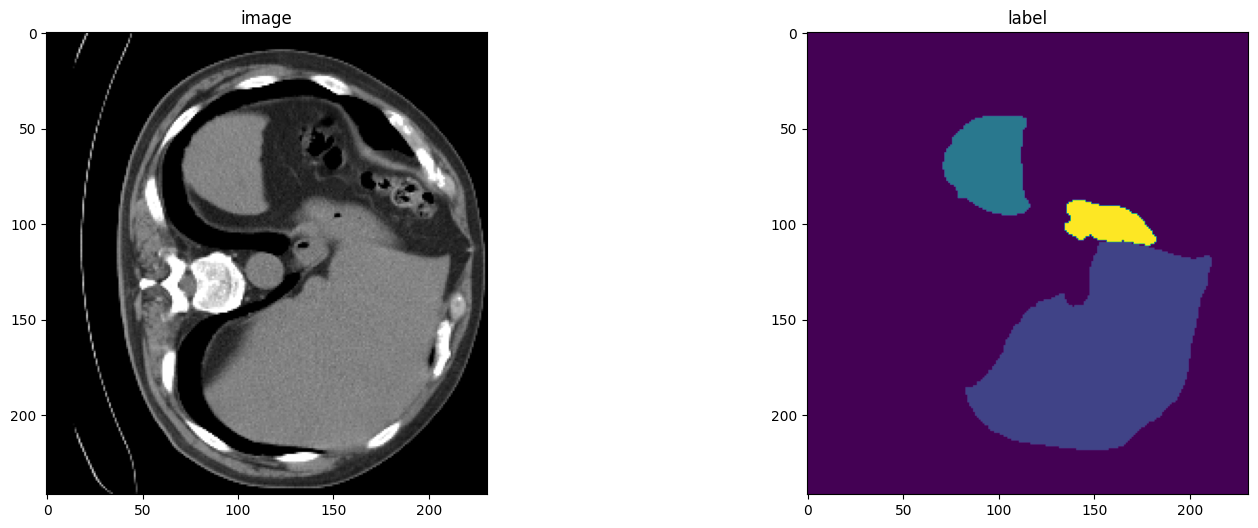

In [10]:
# slice_map = {
#     "img0035.nii.gz": 170,
#     "img0036.nii.gz": 230,
#     "img0037.nii.gz": 204,
#     "img0038.nii.gz": 204,
#     "img0039.nii.gz": 204,
#     "img0040.nii.gz": 180,
# }
slice_map = {
    "img0023.nii.gz": 200,
    "img0024.nii.gz": 230,
    "img0025.nii.gz": 204,
    "img0026.nii.gz": 204,
    "img0027.nii.gz": 204,
    "img0028.nii.gz": 180,
}
case_num = 0
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

In [11]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=8,
    feature_size=48,
    use_checkpoint=True,
).to(device)

In [12]:
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

In [13]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val

def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        with torch.cuda.amp.autocast():
            logit_map = model(x)
            loss = loss_function(logit_map, y)
        scaler.scale(loss).backward()
        epoch_loss += loss.item()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        epoch_iterator.set_description(f"Training ({global_step} / {max_iterations} Steps) (loss={loss:2.5f})")
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr", "swinunetr_fold2_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

In [14]:
max_iterations = 25000#30000
eval_num = 500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr", "swinunetr_fold2_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=2.26625): 100%|█| 24/24 [00:23<00:00,  1.03it/
Training (47 / 25000 Steps) (loss=1.98871): 100%|█| 24/24 [00:18<00:00,  1.29it/
Training (71 / 25000 Steps) (loss=1.90321): 100%|█| 24/24 [00:18<00:00,  1.29it/
Training (95 / 25000 Steps) (loss=1.89275): 100%|█| 24/24 [00:18<00:00,  1.29it/
Training (119 / 25000 Steps) (loss=1.85781): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (143 / 25000 Steps) (loss=1.82930): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (167 / 25000 Steps) (loss=1.78592): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (191 / 25000 Steps) (loss=1.68081): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (215 / 25000 Steps) (loss=1.59432): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (239 / 25000 Steps) (loss=1.54637): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (263 / 25000 Steps) (loss=1.40590): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (287 / 25000 Steps) (loss=1.47739): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.22809533774852753 Current Avg. Dice: 0.22809533774852753


Training (503 / 25000 Steps) (loss=1.33379): 100%|█| 24/24 [00:33<00:00,  1.38s/
Training (527 / 25000 Steps) (loss=1.20867): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (551 / 25000 Steps) (loss=1.33417): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (575 / 25000 Steps) (loss=1.20138): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (599 / 25000 Steps) (loss=1.05572): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (623 / 25000 Steps) (loss=1.13914): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (647 / 25000 Steps) (loss=1.17303): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (671 / 25000 Steps) (loss=1.17084): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (695 / 25000 Steps) (loss=1.14631): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (719 / 25000 Steps) (loss=1.07045): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (743 / 25000 Steps) (loss=1.03214): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (767 / 25000 Steps) (loss=1.10347): 100%|█| 24/24 [00:18<00:00,  1.29it
Training (791 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.3991449177265167 Current Avg. Dice: 0.3991449177265167


Training (1007 / 25000 Steps) (loss=0.97731): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (1031 / 25000 Steps) (loss=1.63825): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1055 / 25000 Steps) (loss=1.05960): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1079 / 25000 Steps) (loss=0.96398): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1103 / 25000 Steps) (loss=0.94155): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1127 / 25000 Steps) (loss=0.97284): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1151 / 25000 Steps) (loss=1.02871): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1175 / 25000 Steps) (loss=1.01108): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1199 / 25000 Steps) (loss=0.96311): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1223 / 25000 Steps) (loss=1.04369): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1247 / 25000 Steps) (loss=1.53639): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1271 / 25000 Steps) (loss=0.90779): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5843751430511475 Current Avg. Dice: 0.5843751430511475


Training (1511 / 25000 Steps) (loss=0.99343): 100%|█| 24/24 [00:32<00:00,  1.34s
Training (1535 / 25000 Steps) (loss=0.85742): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1559 / 25000 Steps) (loss=0.86139): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1583 / 25000 Steps) (loss=0.82653): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1607 / 25000 Steps) (loss=0.93334): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1631 / 25000 Steps) (loss=0.87231): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (1655 / 25000 Steps) (loss=1.09822): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1679 / 25000 Steps) (loss=0.78523): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1703 / 25000 Steps) (loss=0.91336): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1727 / 25000 Steps) (loss=0.82195): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1751 / 25000 Steps) (loss=0.90055): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1775 / 25000 Steps) (loss=0.90534): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6871499419212341 Current Avg. Dice: 0.6871499419212341


Training (2015 / 25000 Steps) (loss=0.82129): 100%|█| 24/24 [00:32<00:00,  1.33s
Training (2039 / 25000 Steps) (loss=0.59281): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2063 / 25000 Steps) (loss=0.79516): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (2087 / 25000 Steps) (loss=0.61307): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2111 / 25000 Steps) (loss=0.68591): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (2135 / 25000 Steps) (loss=0.84249): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2159 / 25000 Steps) (loss=0.73687): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2183 / 25000 Steps) (loss=0.85827): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (2207 / 25000 Steps) (loss=0.75833): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2231 / 25000 Steps) (loss=0.65827): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2255 / 25000 Steps) (loss=0.85400): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2279 / 25000 Steps) (loss=0.63913): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (2303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7145501971244812 Current Avg. Dice: 0.7145501971244812


Training (2519 / 25000 Steps) (loss=0.80431): 100%|█| 24/24 [00:32<00:00,  1.34s
Training (2543 / 25000 Steps) (loss=0.72434): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2567 / 25000 Steps) (loss=0.70723): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2591 / 25000 Steps) (loss=0.87370): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2615 / 25000 Steps) (loss=0.72993): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2639 / 25000 Steps) (loss=0.84842): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2663 / 25000 Steps) (loss=0.74820): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2687 / 25000 Steps) (loss=0.84082): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2711 / 25000 Steps) (loss=0.84050): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (2735 / 25000 Steps) (loss=0.71368): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2759 / 25000 Steps) (loss=0.68790): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2783 / 25000 Steps) (loss=0.59818): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (2807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.75762939453125 Current Avg. Dice: 0.75762939453125


Training (3023 / 25000 Steps) (loss=0.84332): 100%|█| 24/24 [00:32<00:00,  1.33s
Training (3047 / 25000 Steps) (loss=0.76846): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3071 / 25000 Steps) (loss=0.63772): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3095 / 25000 Steps) (loss=0.71133): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3119 / 25000 Steps) (loss=0.81904): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3143 / 25000 Steps) (loss=0.75113): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3167 / 25000 Steps) (loss=0.72500): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (3191 / 25000 Steps) (loss=0.75307): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3215 / 25000 Steps) (loss=0.85882): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3239 / 25000 Steps) (loss=0.65334): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (3263 / 25000 Steps) (loss=0.46765): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3287 / 25000 Steps) (loss=0.70948): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.75762939453125 Current Avg. Dice: 0.7553255558013916


Training (3503 / 25000 Steps) (loss=0.62790): 100%|█| 24/24 [00:31<00:00,  1.32s
Training (3527 / 25000 Steps) (loss=0.59772): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3551 / 25000 Steps) (loss=0.75040): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (3575 / 25000 Steps) (loss=0.55553): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (3599 / 25000 Steps) (loss=0.77425): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3623 / 25000 Steps) (loss=0.75039): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3647 / 25000 Steps) (loss=0.67678): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3671 / 25000 Steps) (loss=0.69687): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3695 / 25000 Steps) (loss=0.83479): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3719 / 25000 Steps) (loss=0.50988): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3743 / 25000 Steps) (loss=0.75705): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3767 / 25000 Steps) (loss=0.83381): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7578540444374084 Current Avg. Dice: 0.7578540444374084


Training (4007 / 25000 Steps) (loss=0.71565): 100%|█| 24/24 [00:32<00:00,  1.34s
Training (4031 / 25000 Steps) (loss=0.52384): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (4055 / 25000 Steps) (loss=0.79743): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (4079 / 25000 Steps) (loss=0.61888): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4103 / 25000 Steps) (loss=0.56964): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4127 / 25000 Steps) (loss=0.68734): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4151 / 25000 Steps) (loss=0.71527): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4175 / 25000 Steps) (loss=0.70692): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (4199 / 25000 Steps) (loss=0.75664): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4223 / 25000 Steps) (loss=0.66683): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4247 / 25000 Steps) (loss=0.80282): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (4271 / 25000 Steps) (loss=0.70832): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7781150937080383 Current Avg. Dice: 0.7781150937080383


Training (4511 / 25000 Steps) (loss=0.56585): 100%|█| 24/24 [00:32<00:00,  1.33s
Training (4535 / 25000 Steps) (loss=0.70727): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4559 / 25000 Steps) (loss=0.69955): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4583 / 25000 Steps) (loss=0.71672): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4607 / 25000 Steps) (loss=0.65050): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4631 / 25000 Steps) (loss=0.70000): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4655 / 25000 Steps) (loss=0.57394): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (4679 / 25000 Steps) (loss=0.59325): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4703 / 25000 Steps) (loss=0.71558): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4727 / 25000 Steps) (loss=0.49825): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4751 / 25000 Steps) (loss=0.50779): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4775 / 25000 Steps) (loss=0.67376): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7781150937080383 Current Avg. Dice: 0.7645625472068787


Training (5015 / 25000 Steps) (loss=0.62213): 100%|█| 24/24 [00:31<00:00,  1.33s
Training (5039 / 25000 Steps) (loss=0.62897): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5063 / 25000 Steps) (loss=0.76993): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5087 / 25000 Steps) (loss=0.70986): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5111 / 25000 Steps) (loss=0.68851): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5135 / 25000 Steps) (loss=0.67361): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5159 / 25000 Steps) (loss=0.59422): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (5183 / 25000 Steps) (loss=0.56711): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5207 / 25000 Steps) (loss=0.96952): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5231 / 25000 Steps) (loss=0.59013): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5255 / 25000 Steps) (loss=0.56274): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (5279 / 25000 Steps) (loss=0.62161): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7781150937080383 Current Avg. Dice: 0.6661419868469238


Training (5519 / 25000 Steps) (loss=0.75226): 100%|█| 24/24 [00:31<00:00,  1.32s
Training (5543 / 25000 Steps) (loss=0.62657): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5567 / 25000 Steps) (loss=1.34634): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5591 / 25000 Steps) (loss=0.80161): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5615 / 25000 Steps) (loss=0.66418): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5639 / 25000 Steps) (loss=0.65268): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5663 / 25000 Steps) (loss=0.55752): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5687 / 25000 Steps) (loss=0.63078): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5711 / 25000 Steps) (loss=0.49396): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5735 / 25000 Steps) (loss=0.71149): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5759 / 25000 Steps) (loss=0.60280): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (5783 / 25000 Steps) (loss=0.54507): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7781150937080383 Current Avg. Dice: 0.7683277130126953


Training (6023 / 25000 Steps) (loss=0.63839): 100%|█| 24/24 [00:31<00:00,  1.32s
Training (6047 / 25000 Steps) (loss=0.69017): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (6071 / 25000 Steps) (loss=0.55908): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6095 / 25000 Steps) (loss=0.68909): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6119 / 25000 Steps) (loss=0.64189): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6143 / 25000 Steps) (loss=0.58268): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6167 / 25000 Steps) (loss=0.88487): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (6191 / 25000 Steps) (loss=0.64216): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6215 / 25000 Steps) (loss=0.46965): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6239 / 25000 Steps) (loss=0.66134): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6263 / 25000 Steps) (loss=0.80682): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (6287 / 25000 Steps) (loss=0.52070): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7781150937080383 Current Avg. Dice: 0.7721753120422363


Training (6503 / 25000 Steps) (loss=0.70104): 100%|█| 24/24 [00:31<00:00,  1.32s
Training (6527 / 25000 Steps) (loss=0.57695): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (6551 / 25000 Steps) (loss=0.67053): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (6575 / 25000 Steps) (loss=0.74516): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (6599 / 25000 Steps) (loss=0.59602): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6623 / 25000 Steps) (loss=0.68590): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6647 / 25000 Steps) (loss=0.61917): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6671 / 25000 Steps) (loss=0.75684): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6695 / 25000 Steps) (loss=0.67865): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6719 / 25000 Steps) (loss=0.69215): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6743 / 25000 Steps) (loss=0.58218): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6767 / 25000 Steps) (loss=0.57180): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7839272618293762 Current Avg. Dice: 0.7839272618293762


Training (7007 / 25000 Steps) (loss=0.38920): 100%|█| 24/24 [00:32<00:00,  1.34s
Training (7031 / 25000 Steps) (loss=0.57295): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7055 / 25000 Steps) (loss=0.87427): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7079 / 25000 Steps) (loss=0.47941): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (7103 / 25000 Steps) (loss=0.54004): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7127 / 25000 Steps) (loss=0.67092): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7151 / 25000 Steps) (loss=0.69733): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7175 / 25000 Steps) (loss=0.55348): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7199 / 25000 Steps) (loss=0.65892): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (7223 / 25000 Steps) (loss=0.77858): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7247 / 25000 Steps) (loss=0.63844): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7271 / 25000 Steps) (loss=0.66951): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (7295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7839272618293762 Current Avg. Dice: 0.7041341662406921


Training (7511 / 25000 Steps) (loss=0.61697): 100%|█| 24/24 [00:31<00:00,  1.32s
Training (7535 / 25000 Steps) (loss=0.66430): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7559 / 25000 Steps) (loss=0.62167): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7583 / 25000 Steps) (loss=0.75074): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7607 / 25000 Steps) (loss=0.52180): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7631 / 25000 Steps) (loss=0.52614): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7655 / 25000 Steps) (loss=0.55115): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7679 / 25000 Steps) (loss=0.44254): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (7703 / 25000 Steps) (loss=0.62274): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7727 / 25000 Steps) (loss=0.86341): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7751 / 25000 Steps) (loss=0.78753): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (7775 / 25000 Steps) (loss=0.68770): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7839272618293762 Current Avg. Dice: 0.7745985984802246


Training (8015 / 25000 Steps) (loss=0.60201): 100%|█| 24/24 [00:31<00:00,  1.32s
Training (8039 / 25000 Steps) (loss=0.63508): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8063 / 25000 Steps) (loss=0.40052): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8087 / 25000 Steps) (loss=0.61627): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8111 / 25000 Steps) (loss=0.34412): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8135 / 25000 Steps) (loss=0.50618): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8159 / 25000 Steps) (loss=0.58074): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8183 / 25000 Steps) (loss=0.52873): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8207 / 25000 Steps) (loss=0.63143): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8231 / 25000 Steps) (loss=0.64878): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8255 / 25000 Steps) (loss=0.45438): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (8279 / 25000 Steps) (loss=0.57376): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7839272618293762 Current Avg. Dice: 0.7570531964302063


Training (8519 / 25000 Steps) (loss=0.70971): 100%|█| 24/24 [00:31<00:00,  1.32s
Training (8543 / 25000 Steps) (loss=0.80856): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (8567 / 25000 Steps) (loss=0.76825): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8591 / 25000 Steps) (loss=0.77715): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8615 / 25000 Steps) (loss=0.68169): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8639 / 25000 Steps) (loss=0.64361): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8663 / 25000 Steps) (loss=0.46203): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8687 / 25000 Steps) (loss=0.59874): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8711 / 25000 Steps) (loss=0.60386): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8735 / 25000 Steps) (loss=0.49443): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8759 / 25000 Steps) (loss=0.50024): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (8783 / 25000 Steps) (loss=0.64241): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7839272618293762 Current Avg. Dice: 0.7660744786262512


Training (9023 / 25000 Steps) (loss=0.47193): 100%|█| 24/24 [00:31<00:00,  1.32s
Training (9047 / 25000 Steps) (loss=0.55226): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (9071 / 25000 Steps) (loss=0.41767): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9095 / 25000 Steps) (loss=0.76180): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9119 / 25000 Steps) (loss=0.67165): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (9143 / 25000 Steps) (loss=0.54753): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9167 / 25000 Steps) (loss=0.86366): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (9191 / 25000 Steps) (loss=0.55757): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9215 / 25000 Steps) (loss=0.50223): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9239 / 25000 Steps) (loss=0.67686): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9263 / 25000 Steps) (loss=0.64257): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9287 / 25000 Steps) (loss=0.64537): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7839272618293762 Current Avg. Dice: 0.7421603798866272


Training (9503 / 25000 Steps) (loss=0.65018): 100%|█| 24/24 [00:31<00:00,  1.32s
Training (9527 / 25000 Steps) (loss=0.64968): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9551 / 25000 Steps) (loss=0.40709): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (9575 / 25000 Steps) (loss=0.64174): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (9599 / 25000 Steps) (loss=0.39681): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9623 / 25000 Steps) (loss=0.53550): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9647 / 25000 Steps) (loss=0.75863): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9671 / 25000 Steps) (loss=0.73238): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9695 / 25000 Steps) (loss=0.46538): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9719 / 25000 Steps) (loss=0.36575): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (9743 / 25000 Steps) (loss=0.53136): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9767 / 25000 Steps) (loss=0.70326): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7839272618293762 Current Avg. Dice: 0.7656486630439758


Training (10007 / 25000 Steps) (loss=0.48159): 100%|█| 24/24 [00:31<00:00,  1.33
Training (10031 / 25000 Steps) (loss=0.57520): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10055 / 25000 Steps) (loss=0.47561): 100%|█| 24/24 [00:18<00:00,  1.30
Training (10079 / 25000 Steps) (loss=0.36848): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10103 / 25000 Steps) (loss=0.58760): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10127 / 25000 Steps) (loss=0.41898): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10151 / 25000 Steps) (loss=0.58759): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10175 / 25000 Steps) (loss=0.48745): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10199 / 25000 Steps) (loss=0.53549): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10223 / 25000 Steps) (loss=0.37099): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10247 / 25000 Steps) (loss=0.38221): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10271 / 25000 Steps) (loss=0.64087): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7884847521781921 Current Avg. Dice: 0.7884847521781921


Training (10511 / 25000 Steps) (loss=0.48497): 100%|█| 24/24 [00:32<00:00,  1.34
Training (10535 / 25000 Steps) (loss=0.45486): 100%|█| 24/24 [00:18<00:00,  1.30
Training (10559 / 25000 Steps) (loss=0.61446): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10583 / 25000 Steps) (loss=0.48964): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10607 / 25000 Steps) (loss=0.52350): 100%|█| 24/24 [00:18<00:00,  1.30
Training (10631 / 25000 Steps) (loss=0.44808): 100%|█| 24/24 [00:18<00:00,  1.30
Training (10655 / 25000 Steps) (loss=0.48393): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10679 / 25000 Steps) (loss=0.73617): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10703 / 25000 Steps) (loss=0.30336): 100%|█| 24/24 [00:18<00:00,  1.30
Training (10727 / 25000 Steps) (loss=0.72612): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10751 / 25000 Steps) (loss=0.76913): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10775 / 25000 Steps) (loss=0.71421): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7884847521781921 Current Avg. Dice: 0.7451805472373962


Training (11015 / 25000 Steps) (loss=0.60266): 100%|█| 24/24 [00:31<00:00,  1.33
Training (11039 / 25000 Steps) (loss=0.32953): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11063 / 25000 Steps) (loss=0.64437): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11087 / 25000 Steps) (loss=0.68088): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11111 / 25000 Steps) (loss=0.61345): 100%|█| 24/24 [00:18<00:00,  1.30
Training (11135 / 25000 Steps) (loss=0.59682): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11159 / 25000 Steps) (loss=0.51023): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11183 / 25000 Steps) (loss=0.69274): 100%|█| 24/24 [00:18<00:00,  1.30
Training (11207 / 25000 Steps) (loss=0.65924): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11231 / 25000 Steps) (loss=0.68012): 100%|█| 24/24 [00:18<00:00,  1.30
Training (11255 / 25000 Steps) (loss=0.58528): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11279 / 25000 Steps) (loss=0.45725): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7884847521781921 Current Avg. Dice: 0.7795745730400085


Training (11519 / 25000 Steps) (loss=0.63020): 100%|█| 24/24 [00:31<00:00,  1.32
Training (11543 / 25000 Steps) (loss=0.45652): 100%|█| 24/24 [00:18<00:00,  1.30
Training (11567 / 25000 Steps) (loss=0.41196): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11591 / 25000 Steps) (loss=0.75009): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11615 / 25000 Steps) (loss=0.42627): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11639 / 25000 Steps) (loss=0.69280): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11663 / 25000 Steps) (loss=0.72866): 100%|█| 24/24 [00:18<00:00,  1.30
Training (11687 / 25000 Steps) (loss=0.72955): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11711 / 25000 Steps) (loss=0.61768): 100%|█| 24/24 [00:18<00:00,  1.30
Training (11735 / 25000 Steps) (loss=0.47684): 100%|█| 24/24 [00:18<00:00,  1.30
Training (11759 / 25000 Steps) (loss=0.50926): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11783 / 25000 Steps) (loss=0.45861): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7884847521781921 Current Avg. Dice: 0.7495642304420471


Training (12023 / 25000 Steps) (loss=0.54676): 100%|█| 24/24 [00:31<00:00,  1.32
Training (12047 / 25000 Steps) (loss=0.60115): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12071 / 25000 Steps) (loss=0.53790): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12095 / 25000 Steps) (loss=0.51139): 100%|█| 24/24 [00:18<00:00,  1.30
Training (12119 / 25000 Steps) (loss=0.56705): 100%|█| 24/24 [00:18<00:00,  1.30
Training (12143 / 25000 Steps) (loss=0.64539): 100%|█| 24/24 [00:18<00:00,  1.30
Training (12167 / 25000 Steps) (loss=0.57040): 100%|█| 24/24 [00:18<00:00,  1.30
Training (12191 / 25000 Steps) (loss=0.67598): 100%|█| 24/24 [00:18<00:00,  1.30
Training (12215 / 25000 Steps) (loss=0.75523): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12239 / 25000 Steps) (loss=0.67697): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12263 / 25000 Steps) (loss=0.69419): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12287 / 25000 Steps) (loss=0.47558): 100%|█| 24/24 [00:18<00:00,  1.30
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7884847521781921 Current Avg. Dice: 0.7727000713348389


Training (12503 / 25000 Steps) (loss=0.63561): 100%|█| 24/24 [00:31<00:00,  1.32
Training (12527 / 25000 Steps) (loss=0.38796): 100%|█| 24/24 [00:18<00:00,  1.30
Training (12551 / 25000 Steps) (loss=0.38441): 100%|█| 24/24 [00:18<00:00,  1.30
Training (12575 / 25000 Steps) (loss=0.81275): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12599 / 25000 Steps) (loss=0.75536): 100%|█| 24/24 [00:18<00:00,  1.30
Training (12623 / 25000 Steps) (loss=0.37195): 100%|█| 24/24 [00:18<00:00,  1.30
Training (12647 / 25000 Steps) (loss=0.50983): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12671 / 25000 Steps) (loss=0.56121): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12695 / 25000 Steps) (loss=0.60121): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12719 / 25000 Steps) (loss=0.65602): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12743 / 25000 Steps) (loss=0.43862): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12767 / 25000 Steps) (loss=0.49972): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12791 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8033010363578796 Current Avg. Dice: 0.8033010363578796


Training (13007 / 25000 Steps) (loss=0.58225): 100%|█| 24/24 [00:32<00:00,  1.35
Training (13031 / 25000 Steps) (loss=0.36984): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13055 / 25000 Steps) (loss=0.70812): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13079 / 25000 Steps) (loss=0.53693): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13103 / 25000 Steps) (loss=0.59644): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13127 / 25000 Steps) (loss=0.52739): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13151 / 25000 Steps) (loss=0.41688): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13175 / 25000 Steps) (loss=0.59475): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13199 / 25000 Steps) (loss=0.42404): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13223 / 25000 Steps) (loss=0.71251): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13247 / 25000 Steps) (loss=0.62568): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13271 / 25000 Steps) (loss=0.60935): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8033010363578796 Current Avg. Dice: 0.7751104831695557


Training (13511 / 25000 Steps) (loss=0.68909): 100%|█| 24/24 [00:32<00:00,  1.34
Training (13535 / 25000 Steps) (loss=0.60410): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13559 / 25000 Steps) (loss=0.36826): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13583 / 25000 Steps) (loss=0.54836): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13607 / 25000 Steps) (loss=0.62706): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13631 / 25000 Steps) (loss=0.45815): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13655 / 25000 Steps) (loss=0.68205): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13679 / 25000 Steps) (loss=0.57865): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13703 / 25000 Steps) (loss=0.29913): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13727 / 25000 Steps) (loss=0.36172): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13751 / 25000 Steps) (loss=1.10863): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13775 / 25000 Steps) (loss=0.41932): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8033010363578796 Current Avg. Dice: 0.7721840739250183


Training (14015 / 25000 Steps) (loss=0.63837): 100%|█| 24/24 [00:31<00:00,  1.32
Training (14039 / 25000 Steps) (loss=0.56091): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14063 / 25000 Steps) (loss=0.52495): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14087 / 25000 Steps) (loss=0.61651): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14111 / 25000 Steps) (loss=0.42607): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14135 / 25000 Steps) (loss=0.49070): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14159 / 25000 Steps) (loss=0.73166): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14183 / 25000 Steps) (loss=0.62291): 100%|█| 24/24 [00:18<00:00,  1.30
Training (14207 / 25000 Steps) (loss=0.75195): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14231 / 25000 Steps) (loss=0.65429): 100%|█| 24/24 [00:18<00:00,  1.30
Training (14255 / 25000 Steps) (loss=0.45415): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14279 / 25000 Steps) (loss=0.74318): 100%|█| 24/24 [00:18<00:00,  1.30
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8033010363578796 Current Avg. Dice: 0.7988593578338623


Training (14519 / 25000 Steps) (loss=0.64338): 100%|█| 24/24 [00:31<00:00,  1.32
Training (14543 / 25000 Steps) (loss=0.63075): 100%|█| 24/24 [00:18<00:00,  1.30
Training (14567 / 25000 Steps) (loss=0.63559): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14591 / 25000 Steps) (loss=0.75777): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14615 / 25000 Steps) (loss=0.44401): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14639 / 25000 Steps) (loss=0.65532): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14663 / 25000 Steps) (loss=0.54944): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14687 / 25000 Steps) (loss=0.39182): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14711 / 25000 Steps) (loss=0.64061): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14735 / 25000 Steps) (loss=0.37980): 100%|█| 24/24 [00:18<00:00,  1.30
Training (14759 / 25000 Steps) (loss=0.39515): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14783 / 25000 Steps) (loss=0.54882): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8033010363578796 Current Avg. Dice: 0.7961025834083557


Training (15023 / 25000 Steps) (loss=0.58831): 100%|█| 24/24 [00:31<00:00,  1.32
Training (15047 / 25000 Steps) (loss=0.51789): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15071 / 25000 Steps) (loss=0.61864): 100%|█| 24/24 [00:18<00:00,  1.30
Training (15095 / 25000 Steps) (loss=0.43485): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15119 / 25000 Steps) (loss=0.70416): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15143 / 25000 Steps) (loss=0.55648): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15167 / 25000 Steps) (loss=0.61289): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15191 / 25000 Steps) (loss=0.44715): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15215 / 25000 Steps) (loss=0.49024): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15239 / 25000 Steps) (loss=0.66051): 100%|█| 24/24 [00:18<00:00,  1.30
Training (15263 / 25000 Steps) (loss=0.66960): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15287 / 25000 Steps) (loss=0.36369): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8033010363578796 Current Avg. Dice: 0.7430631518363953


Training (15503 / 25000 Steps) (loss=0.58540): 100%|█| 24/24 [00:31<00:00,  1.33
Training (15527 / 25000 Steps) (loss=0.61938): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15551 / 25000 Steps) (loss=0.45950): 100%|█| 24/24 [00:18<00:00,  1.30
Training (15575 / 25000 Steps) (loss=0.65535): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15599 / 25000 Steps) (loss=0.63930): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15623 / 25000 Steps) (loss=0.49589): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15647 / 25000 Steps) (loss=0.63183): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15671 / 25000 Steps) (loss=0.48785): 100%|█| 24/24 [00:18<00:00,  1.30
Training (15695 / 25000 Steps) (loss=0.61955): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15719 / 25000 Steps) (loss=0.70376): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15743 / 25000 Steps) (loss=0.71598): 100%|█| 24/24 [00:18<00:00,  1.30
Training (15767 / 25000 Steps) (loss=0.68758): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8033010363578796 Current Avg. Dice: 0.7867404818534851


Training (16007 / 25000 Steps) (loss=0.52940): 100%|█| 24/24 [00:31<00:00,  1.32
Training (16031 / 25000 Steps) (loss=0.42336): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16055 / 25000 Steps) (loss=0.59279): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16079 / 25000 Steps) (loss=0.51278): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16103 / 25000 Steps) (loss=0.41659): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16127 / 25000 Steps) (loss=0.52139): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16151 / 25000 Steps) (loss=0.38604): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16175 / 25000 Steps) (loss=0.54413): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16199 / 25000 Steps) (loss=0.48316): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16223 / 25000 Steps) (loss=0.26272): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16247 / 25000 Steps) (loss=0.61081): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16271 / 25000 Steps) (loss=0.57505): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8033010363578796 Current Avg. Dice: 0.7603837847709656


Training (16511 / 25000 Steps) (loss=0.55572): 100%|█| 24/24 [00:31<00:00,  1.32
Training (16535 / 25000 Steps) (loss=0.67490): 100%|█| 24/24 [00:18<00:00,  1.30
Training (16559 / 25000 Steps) (loss=0.32510): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16583 / 25000 Steps) (loss=0.39952): 100%|█| 24/24 [00:18<00:00,  1.30
Training (16607 / 25000 Steps) (loss=0.42216): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16631 / 25000 Steps) (loss=0.58589): 100%|█| 24/24 [00:18<00:00,  1.30
Training (16655 / 25000 Steps) (loss=0.68831): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16679 / 25000 Steps) (loss=0.30744): 100%|█| 24/24 [00:18<00:00,  1.30
Training (16703 / 25000 Steps) (loss=0.47873): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16727 / 25000 Steps) (loss=0.64278): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16751 / 25000 Steps) (loss=0.66890): 100%|█| 24/24 [00:18<00:00,  1.30
Training (16775 / 25000 Steps) (loss=0.57328): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8033010363578796 Current Avg. Dice: 0.7793886065483093


Training (17015 / 25000 Steps) (loss=0.52523): 100%|█| 24/24 [00:31<00:00,  1.32
Training (17039 / 25000 Steps) (loss=0.41098): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17063 / 25000 Steps) (loss=0.42756): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17087 / 25000 Steps) (loss=0.48049): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17111 / 25000 Steps) (loss=0.61085): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17135 / 25000 Steps) (loss=0.64751): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17159 / 25000 Steps) (loss=0.76418): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17183 / 25000 Steps) (loss=0.43304): 100%|█| 24/24 [00:18<00:00,  1.30
Training (17207 / 25000 Steps) (loss=0.61774): 100%|█| 24/24 [00:18<00:00,  1.30
Training (17231 / 25000 Steps) (loss=0.50445): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17255 / 25000 Steps) (loss=0.63104): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17279 / 25000 Steps) (loss=0.55780): 100%|█| 24/24 [00:18<00:00,  1.30
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8033010363578796 Current Avg. Dice: 0.6152966618537903


Training (17519 / 25000 Steps) (loss=0.38513): 100%|█| 24/24 [00:31<00:00,  1.32
Training (17543 / 25000 Steps) (loss=1.29102): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17567 / 25000 Steps) (loss=0.62282): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17591 / 25000 Steps) (loss=0.66794): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17615 / 25000 Steps) (loss=0.68629): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17639 / 25000 Steps) (loss=0.94175): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17663 / 25000 Steps) (loss=0.49743): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17687 / 25000 Steps) (loss=0.49271): 100%|█| 24/24 [00:18<00:00,  1.30
Training (17711 / 25000 Steps) (loss=0.35413): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17735 / 25000 Steps) (loss=0.56825): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17759 / 25000 Steps) (loss=0.73338): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17783 / 25000 Steps) (loss=0.55883): 100%|█| 24/24 [00:18<00:00,  1.30
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8033010363578796 Current Avg. Dice: 0.7829931378364563


Training (18023 / 25000 Steps) (loss=0.39327): 100%|█| 24/24 [00:31<00:00,  1.33
Training (18047 / 25000 Steps) (loss=0.51787): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18071 / 25000 Steps) (loss=0.48925): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18095 / 25000 Steps) (loss=0.45643): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18119 / 25000 Steps) (loss=0.54136): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18143 / 25000 Steps) (loss=0.61709): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18167 / 25000 Steps) (loss=0.61521): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18191 / 25000 Steps) (loss=0.74780): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18215 / 25000 Steps) (loss=0.56854): 100%|█| 24/24 [00:18<00:00,  1.30
Training (18239 / 25000 Steps) (loss=0.57791): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18263 / 25000 Steps) (loss=0.47976): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18287 / 25000 Steps) (loss=0.41729): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8033010363578796 Current Avg. Dice: 0.751602828502655


Training (18503 / 25000 Steps) (loss=0.44890): 100%|█| 24/24 [00:31<00:00,  1.33
Training (18527 / 25000 Steps) (loss=0.63693): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18551 / 25000 Steps) (loss=0.73549): 100%|█| 24/24 [00:18<00:00,  1.30
Training (18575 / 25000 Steps) (loss=0.63601): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18599 / 25000 Steps) (loss=0.37277): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18623 / 25000 Steps) (loss=0.37117): 100%|█| 24/24 [00:18<00:00,  1.30
Training (18647 / 25000 Steps) (loss=0.69761): 100%|█| 24/24 [00:18<00:00,  1.30
Training (18671 / 25000 Steps) (loss=0.46720): 100%|█| 24/24 [00:18<00:00,  1.30
Training (18695 / 25000 Steps) (loss=0.70703): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18719 / 25000 Steps) (loss=0.50057): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18743 / 25000 Steps) (loss=0.53891): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18767 / 25000 Steps) (loss=0.32915): 100%|█| 24/24 [00:18<00:00,  1.30
Training (18791 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8159666061401367 Current Avg. Dice: 0.8159666061401367


Training (19007 / 25000 Steps) (loss=0.44536): 100%|█| 24/24 [00:32<00:00,  1.34
Training (19031 / 25000 Steps) (loss=0.74111): 100%|█| 24/24 [00:18<00:00,  1.30
Training (19055 / 25000 Steps) (loss=0.33672): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19079 / 25000 Steps) (loss=0.56451): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19103 / 25000 Steps) (loss=0.51448): 100%|█| 24/24 [00:18<00:00,  1.30
Training (19127 / 25000 Steps) (loss=0.56771): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19151 / 25000 Steps) (loss=0.52540): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19175 / 25000 Steps) (loss=0.52371): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19199 / 25000 Steps) (loss=0.62032): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19223 / 25000 Steps) (loss=0.65412): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19247 / 25000 Steps) (loss=0.35321): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19271 / 25000 Steps) (loss=0.43370): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8159666061401367 Current Avg. Dice: 0.8150219321250916


Training (19511 / 25000 Steps) (loss=0.58964): 100%|█| 24/24 [00:31<00:00,  1.32
Training (19535 / 25000 Steps) (loss=0.50674): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19559 / 25000 Steps) (loss=0.41132): 100%|█| 24/24 [00:18<00:00,  1.30
Training (19583 / 25000 Steps) (loss=0.56594): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19607 / 25000 Steps) (loss=0.56431): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19631 / 25000 Steps) (loss=0.61937): 100%|█| 24/24 [00:18<00:00,  1.30
Training (19655 / 25000 Steps) (loss=0.54809): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19679 / 25000 Steps) (loss=0.65727): 100%|█| 24/24 [00:18<00:00,  1.30
Training (19703 / 25000 Steps) (loss=0.57454): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19727 / 25000 Steps) (loss=0.43055): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19751 / 25000 Steps) (loss=0.61687): 100%|█| 24/24 [00:18<00:00,  1.30
Training (19775 / 25000 Steps) (loss=0.40530): 100%|█| 24/24 [00:18<00:00,  1.30
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8159666061401367 Current Avg. Dice: 0.7770151495933533


Training (20015 / 25000 Steps) (loss=0.53850): 100%|█| 24/24 [00:31<00:00,  1.33
Training (20039 / 25000 Steps) (loss=0.35278): 100%|█| 24/24 [00:18<00:00,  1.30
Training (20063 / 25000 Steps) (loss=0.41080): 100%|█| 24/24 [00:18<00:00,  1.30
Training (20087 / 25000 Steps) (loss=0.58256): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20111 / 25000 Steps) (loss=0.71420): 100%|█| 24/24 [00:18<00:00,  1.30
Training (20135 / 25000 Steps) (loss=0.59797): 100%|█| 24/24 [00:18<00:00,  1.30
Training (20159 / 25000 Steps) (loss=0.62746): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20183 / 25000 Steps) (loss=0.40501): 100%|█| 24/24 [00:18<00:00,  1.30
Training (20207 / 25000 Steps) (loss=0.76927): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20231 / 25000 Steps) (loss=0.40118): 100%|█| 24/24 [00:18<00:00,  1.30
Training (20255 / 25000 Steps) (loss=0.44420): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20279 / 25000 Steps) (loss=0.45571): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8159666061401367 Current Avg. Dice: 0.7697928547859192


Training (20519 / 25000 Steps) (loss=0.39370): 100%|█| 24/24 [00:31<00:00,  1.32
Training (20543 / 25000 Steps) (loss=0.55095): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20567 / 25000 Steps) (loss=0.81058): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20591 / 25000 Steps) (loss=0.52627): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20615 / 25000 Steps) (loss=0.33531): 100%|█| 24/24 [00:18<00:00,  1.30
Training (20639 / 25000 Steps) (loss=0.64160): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20663 / 25000 Steps) (loss=0.42718): 100%|█| 24/24 [00:18<00:00,  1.30
Training (20687 / 25000 Steps) (loss=0.59593): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20711 / 25000 Steps) (loss=0.57544): 100%|█| 24/24 [00:18<00:00,  1.30
Training (20735 / 25000 Steps) (loss=0.74172): 100%|█| 24/24 [00:18<00:00,  1.30
Training (20759 / 25000 Steps) (loss=0.50102): 100%|█| 24/24 [00:18<00:00,  1.30
Training (20783 / 25000 Steps) (loss=0.54832): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8159666061401367 Current Avg. Dice: 0.7933419346809387


Training (21023 / 25000 Steps) (loss=0.35472): 100%|█| 24/24 [00:31<00:00,  1.33
Training (21047 / 25000 Steps) (loss=0.41466): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21071 / 25000 Steps) (loss=0.33030): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21095 / 25000 Steps) (loss=0.74824): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21119 / 25000 Steps) (loss=0.80468): 100%|█| 24/24 [00:18<00:00,  1.30
Training (21143 / 25000 Steps) (loss=0.67916): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21167 / 25000 Steps) (loss=0.61370): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21191 / 25000 Steps) (loss=0.55862): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21215 / 25000 Steps) (loss=0.54180): 100%|█| 24/24 [00:18<00:00,  1.30
Training (21239 / 25000 Steps) (loss=0.78459): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21263 / 25000 Steps) (loss=0.56593): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21287 / 25000 Steps) (loss=0.47953): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8159666061401367 Current Avg. Dice: 0.7662214636802673


Training (21503 / 25000 Steps) (loss=0.50897): 100%|█| 24/24 [00:31<00:00,  1.32
Training (21527 / 25000 Steps) (loss=0.54877): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21551 / 25000 Steps) (loss=0.45255): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21575 / 25000 Steps) (loss=0.56119): 100%|█| 24/24 [00:18<00:00,  1.30
Training (21599 / 25000 Steps) (loss=0.48126): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21623 / 25000 Steps) (loss=0.53897): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21647 / 25000 Steps) (loss=0.59866): 100%|█| 24/24 [00:18<00:00,  1.30
Training (21671 / 25000 Steps) (loss=0.65955): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21695 / 25000 Steps) (loss=0.68841): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21719 / 25000 Steps) (loss=0.66049): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21743 / 25000 Steps) (loss=0.67512): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21767 / 25000 Steps) (loss=0.43868): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8159666061401367 Current Avg. Dice: 0.7609834671020508


Training (22007 / 25000 Steps) (loss=0.74234): 100%|█| 24/24 [00:31<00:00,  1.33
Training (22031 / 25000 Steps) (loss=0.63092): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22055 / 25000 Steps) (loss=0.25284): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22079 / 25000 Steps) (loss=0.68610): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22103 / 25000 Steps) (loss=0.34709): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22127 / 25000 Steps) (loss=0.63196): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22151 / 25000 Steps) (loss=0.48017): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22175 / 25000 Steps) (loss=0.78621): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22199 / 25000 Steps) (loss=0.57052): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22223 / 25000 Steps) (loss=0.75904): 100%|█| 24/24 [00:18<00:00,  1.30
Training (22247 / 25000 Steps) (loss=0.60138): 100%|█| 24/24 [00:18<00:00,  1.30
Training (22271 / 25000 Steps) (loss=0.99278): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8159666061401367 Current Avg. Dice: 0.6972735524177551


Training (22511 / 25000 Steps) (loss=0.47846): 100%|█| 24/24 [00:31<00:00,  1.33
Training (22535 / 25000 Steps) (loss=0.66558): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22559 / 25000 Steps) (loss=0.50216): 100%|█| 24/24 [00:18<00:00,  1.30
Training (22583 / 25000 Steps) (loss=0.44826): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22607 / 25000 Steps) (loss=0.66181): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22631 / 25000 Steps) (loss=0.71367): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22655 / 25000 Steps) (loss=0.47342): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22679 / 25000 Steps) (loss=0.59601): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22703 / 25000 Steps) (loss=0.46485): 100%|█| 24/24 [00:18<00:00,  1.30
Training (22727 / 25000 Steps) (loss=0.41764): 100%|█| 24/24 [00:18<00:00,  1.30
Training (22751 / 25000 Steps) (loss=0.79208): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22775 / 25000 Steps) (loss=0.56067): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8159666061401367 Current Avg. Dice: 0.737221896648407


Training (23015 / 25000 Steps) (loss=0.39377): 100%|█| 24/24 [00:31<00:00,  1.33
Training (23039 / 25000 Steps) (loss=0.49077): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23063 / 25000 Steps) (loss=0.49133): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23087 / 25000 Steps) (loss=0.47432): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23111 / 25000 Steps) (loss=0.67030): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23135 / 25000 Steps) (loss=0.46359): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23159 / 25000 Steps) (loss=0.60327): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23183 / 25000 Steps) (loss=0.42886): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23207 / 25000 Steps) (loss=0.48628): 100%|█| 24/24 [00:18<00:00,  1.30
Training (23231 / 25000 Steps) (loss=0.65338): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23255 / 25000 Steps) (loss=0.35618): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23279 / 25000 Steps) (loss=0.64752): 100%|█| 24/24 [00:18<00:00,  1.30
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8159666061401367 Current Avg. Dice: 0.7997762560844421


Training (23519 / 25000 Steps) (loss=0.33763): 100%|█| 24/24 [00:31<00:00,  1.32
Training (23543 / 25000 Steps) (loss=0.48674): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23567 / 25000 Steps) (loss=0.52569): 100%|█| 24/24 [00:18<00:00,  1.30
Training (23591 / 25000 Steps) (loss=0.48188): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23615 / 25000 Steps) (loss=0.56248): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23639 / 25000 Steps) (loss=0.49533): 100%|█| 24/24 [00:18<00:00,  1.30
Training (23663 / 25000 Steps) (loss=0.47850): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23687 / 25000 Steps) (loss=0.44213): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23711 / 25000 Steps) (loss=0.46989): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23735 / 25000 Steps) (loss=0.45437): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23759 / 25000 Steps) (loss=0.38719): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23783 / 25000 Steps) (loss=0.57287): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8159666061401367 Current Avg. Dice: 0.7504067420959473


Training (24023 / 25000 Steps) (loss=0.36970): 100%|█| 24/24 [00:31<00:00,  1.32
Training (24047 / 25000 Steps) (loss=0.58853): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24071 / 25000 Steps) (loss=0.56080): 100%|█| 24/24 [00:18<00:00,  1.30
Training (24095 / 25000 Steps) (loss=0.59987): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24119 / 25000 Steps) (loss=0.48737): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24143 / 25000 Steps) (loss=0.63948): 100%|█| 24/24 [00:18<00:00,  1.30
Training (24167 / 25000 Steps) (loss=0.42163): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24191 / 25000 Steps) (loss=0.45087): 100%|█| 24/24 [00:18<00:00,  1.30
Training (24215 / 25000 Steps) (loss=0.42910): 100%|█| 24/24 [00:18<00:00,  1.30
Training (24239 / 25000 Steps) (loss=0.46168): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24263 / 25000 Steps) (loss=0.55794): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24287 / 25000 Steps) (loss=0.73749): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8159666061401367 Current Avg. Dice: 0.7596215605735779


Training (24503 / 25000 Steps) (loss=0.60546): 100%|█| 24/24 [00:31<00:00,  1.32
Training (24527 / 25000 Steps) (loss=0.62465): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24551 / 25000 Steps) (loss=0.43659): 100%|█| 24/24 [00:18<00:00,  1.30
Training (24575 / 25000 Steps) (loss=0.58187): 100%|█| 24/24 [00:18<00:00,  1.30
Training (24599 / 25000 Steps) (loss=0.34762): 100%|█| 24/24 [00:18<00:00,  1.30
Training (24623 / 25000 Steps) (loss=0.48544): 100%|█| 24/24 [00:18<00:00,  1.30
Training (24647 / 25000 Steps) (loss=0.45649): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24671 / 25000 Steps) (loss=0.50201): 100%|█| 24/24 [00:18<00:00,  1.30
Training (24695 / 25000 Steps) (loss=0.74521): 100%|█| 24/24 [00:18<00:00,  1.30
Training (24719 / 25000 Steps) (loss=0.45704): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24743 / 25000 Steps) (loss=0.52236): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24767 / 25000 Steps) (loss=0.51596): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8159666061401367 Current Avg. Dice: 0.7464531064033508


Training (25007 / 25000 Steps) (loss=0.38734): 100%|█| 24/24 [00:31<00:00,  1.32


<All keys matched successfully>

In [15]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.8160 at iteration: 19000


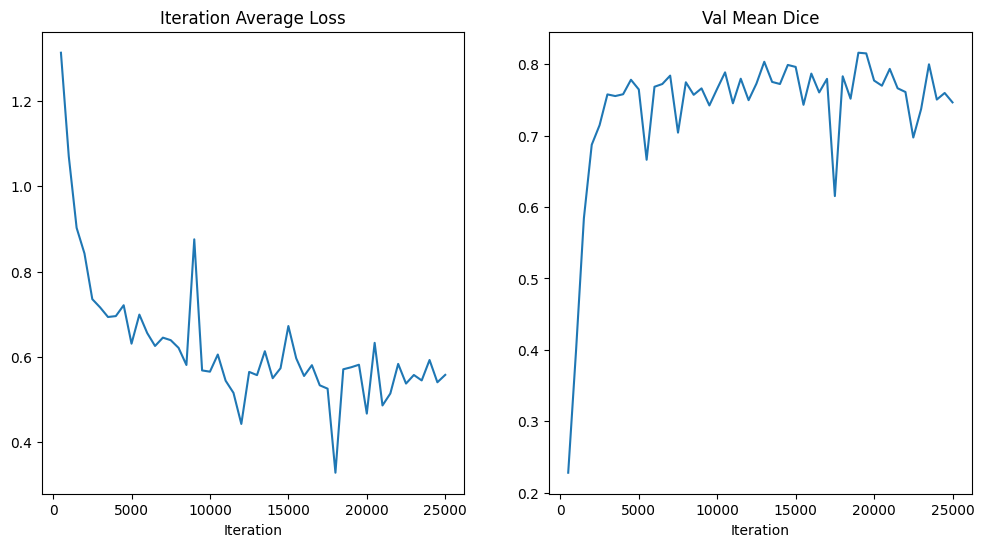

In [16]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

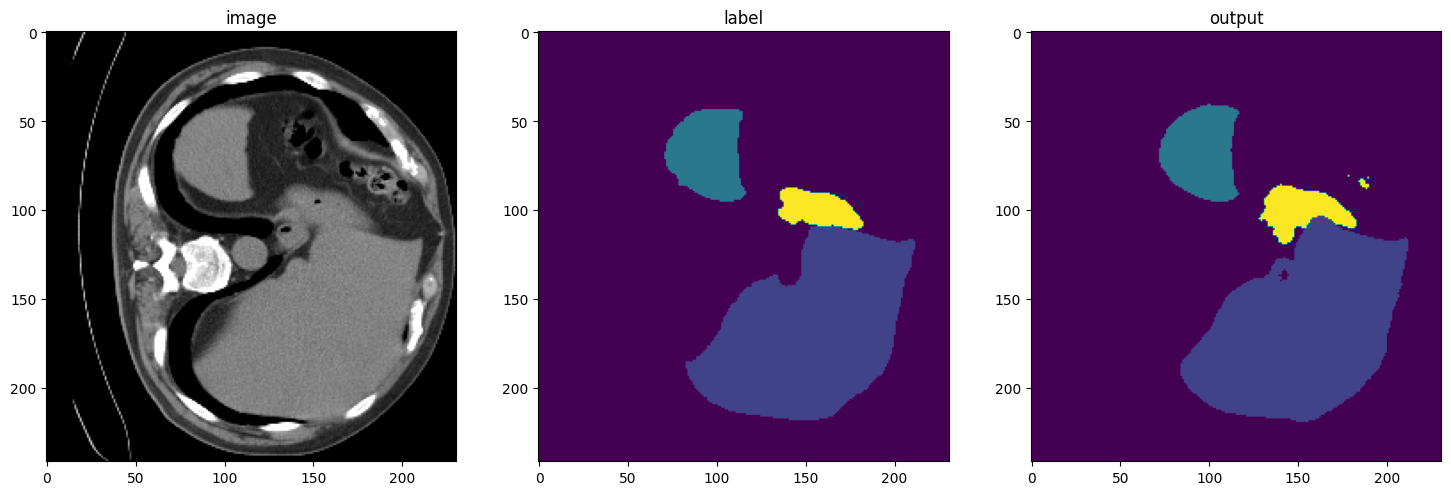

In [18]:
case_num = 0
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr", "swinunetr_fold2_best_metric_model.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
    plt.show()